In [78]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle
import pickle
import h5py
import json
import matplotlib.pyplot as plt 

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk import word_tokenize

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.models import model_from_json


# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\tqdm\std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [79]:
# load the dataset but only keep the top n words, zero the rest


def ingest():
    data = pd.read_csv('twt_#ifc.csv', encoding = 'unicode_escape')

    data.drop(['retweet_count', 'user_followers_count','favorite_count','created_at'], axis=1, inplace=True)
    data = data[data.sent_score.isnull() == False]
    data['sent_score'] = data['sent_score'] 
    data = data[data['full_text'].isnull() == False]
    data.reset_index(inplace=True)
    print ('dataset loaded with shape', data.shape  )  
    return data

data = ingest()

dataset loaded with shape (1749, 5)


In [80]:
tokenizer = TweetTokenizer()
def tokenize(tweet):
    try:
        tweet = tweet.lower()
        tokens = tokenizer.tokenize(tweet)
        tokens = list(filter(lambda t: not t.startswith('@'), tokens))
        tokens = list(filter(lambda t: not t.startswith('#'), tokens))
        tokens = list(filter(lambda t: not t.startswith('http'), tokens))
        return tokens
    except:
        return 'NC'

In [81]:
def postprocess(data):
#     , n=1000000
#     data = data.head(n)
    data['tokens'] = data['full_text'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    return data

data = postprocess(data)

progress-bar: 100%|██████████| 1749/1749 [00:00<00:00, 8976.32it/s]


In [82]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence   # we'll talk about this down below

def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [83]:
#Splitting for training and testing
x_train, x_test, y_train, y_test = train_test_split(np.array(data.head(1000000).tokens),
                                                    np.array(data.head(1000000).sent_score), test_size=0.5)

In [84]:

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

0it [00:00, ?it/s]C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
874it [00:00, 3389.32it/s]
875it [00:00, 26672.21it/s]


In [85]:
data_labellised= labelizeTweets(np.array(data.tokens), 'data')


0it [00:00, ?it/s]C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
1749it [00:00, 30707.24it/s]


In [86]:
n=1000000
n_dim = 200
tweet_w2v = Word2Vec(size=n_dim, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(data_labellised)])

100%|██████████| 1749/1749 [00:00<00:00, 44187.53it/s]


In [87]:
tweet_w2v.train([x.words for x in tqdm(data_labellised)],total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter)

100%|██████████| 1749/1749 [00:00<00:00, 42527.58it/s]
C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(56221, 119920)

In [94]:

#convert any word(present in vocabulary) to vector.
tweet_w2v['lockdown']

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.07495142,  0.11252681,  0.10219862,  0.1558719 , -0.17599706,
       -0.34927046, -0.07439105,  0.18110028,  0.22482291,  0.17516516,
        0.0615545 , -0.11598469, -0.10641216, -0.24474855,  0.498073  ,
       -0.01775535, -0.24704866, -0.40503216,  0.12694785,  0.20489056,
       -0.0892111 , -0.20057605,  0.11171182, -0.52594334,  0.14538248,
        0.25747594,  0.10392675,  0.15069787,  0.0251837 ,  0.50248116,
        0.23617636, -0.18125317, -0.3519759 , -0.06263576,  0.26682612,
       -0.21610968,  0.44079795, -0.09280396,  0.2820851 , -0.328941  ,
        0.03558358,  0.02738336,  0.1459972 , -0.33582953,  0.25899774,
       -0.13884583, -0.01931834, -0.08229905,  0.34721637,  0.46892038,
        0.23518896,  0.1105132 , -0.00890602, -0.1542078 ,  0.14644992,
        0.23050545, -0.41679782, -0.30958593,  0.22148257,  0.33235446,
        0.16230674, -0.27830526,  0.09514465,  0.21221256,  0.44573975,
       -0.06803819, -0.2716138 , -0.06364063, -0.117065  ,  0.05

In [95]:
#Find similar words
tweet_w2v.most_similar('corona')

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('covid', 0.9999251365661621),
 ('day', 0.9999211430549622),
 ('indiafightscorona', 0.9999196529388428),
 ('amp', 0.999914824962616),
 ('lockdown', 0.999914288520813),
 ('peopl', 0.9999141693115234),
 ('need', 0.9999101161956787),
 ('pandem', 0.9999085664749146),
 ('also', 0.9999063014984131),
 ('work', 0.9999057054519653)]

In [96]:
tweet_w2v.most_similar('lockdown')

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('covid', 0.999955415725708),
 ('open', 0.9999538660049438),
 ('indiafightscorona', 0.9999522566795349),
 ('amp', 0.9999501705169678),
 ('help', 0.9999486207962036),
 ('india', 0.9999454021453857),
 ('state', 0.9999448657035828),
 ('time', 0.9999445676803589),
 ('peopl', 0.9999427795410156),
 ('the', 0.9999423027038574)]

In [98]:

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=500, plot_height=500, title="A map of 10000 word vectors",
                        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                        x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [tweet_w2v[w] for w in list(tweet_w2v.wv.vocab.keys())[:1000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:1000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 514 samples in 0.021s...
[t-SNE] Computed neighbors for 514 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 514 / 514
[t-SNE] Mean sigma: 0.026908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.365013
[t-SNE] KL divergence after 1000 iterations: 0.154740


In [99]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in data_labellised])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 499


In [100]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word] #combining w2v vectors with tfidf value of words in the tweet.
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [101]:

train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

0it [00:00, ?it/s]C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
874it [00:00, 3332.07it/s]
0it [00:00, ?it/s]C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
875it [00:00, 3863.48it/s]


In [108]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=1000, batch_size=100, verbose=2)

Epoch 1/1000
 - 1s - loss: 0.7391 - accuracy: 0.3352
Epoch 2/1000
 - 0s - loss: 0.6646 - accuracy: 0.1831
Epoch 3/1000
 - 0s - loss: 0.6388 - accuracy: 0.1636
Epoch 4/1000
 - 0s - loss: 0.6102 - accuracy: 0.1613
Epoch 5/1000
 - 0s - loss: 0.6080 - accuracy: 0.1659
Epoch 6/1000
 - 0s - loss: 0.6055 - accuracy: 0.1659
Epoch 7/1000
 - 0s - loss: 0.6030 - accuracy: 0.1625
Epoch 8/1000
 - 0s - loss: 0.5951 - accuracy: 0.1705
Epoch 9/1000
 - 0s - loss: 0.5906 - accuracy: 0.1716
Epoch 10/1000
 - 0s - loss: 0.5916 - accuracy: 0.1693
Epoch 11/1000
 - 0s - loss: 0.5936 - accuracy: 0.1693
Epoch 12/1000
 - 0s - loss: 0.5914 - accuracy: 0.1831
Epoch 13/1000
 - 0s - loss: 0.5869 - accuracy: 0.1854
Epoch 14/1000
 - 0s - loss: 0.5835 - accuracy: 0.1819
Epoch 15/1000
 - 0s - loss: 0.5767 - accuracy: 0.1831
Epoch 16/1000
 - 0s - loss: 0.5739 - accuracy: 0.1911
Epoch 17/1000
 - 0s - loss: 0.5709 - accuracy: 0.1911
Epoch 18/1000
 - 0s - loss: 0.5671 - accuracy: 0.1865
Epoch 19/1000
 - 0s - loss: 0.5714 - 

In [111]:
# Evaluating accuracy score

score = model.evaluate(test_vecs_w2v, y_test, batch_size=100, verbose=2)
print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])

loss :  -6223.559849330357 
 accuracy :  0.2800000011920929


In [118]:
def ingesttest():
    testdata = pd.read_csv('nit1.csv', encoding='latin-1')
    testdata.drop(['retweet_count', 'user_followers_count','favorite_count','created_at'], axis=1, inplace=True)
    testdata = testdata[testdata.sent_score.isnull() == False]
    testdata['sent_score'] = testdata['sent_score'] #Converting 4 to 1
    testdata = testdata[data['full_text'].isnull() == False]
    testdata.reset_index(inplace=True)
    print ('dataset loaded with shape', testdata.shape  )  
    return testdata

testdata = ingesttest()

dataset loaded with shape (517, 5)


C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [113]:
testdata = postprocess(testdata)
testdata.head(5)

progress-bar: 100%|██████████| 517/517 [00:00<00:00, 10571.54it/s]


,level_0,index,full_text,pos_score,neg_score,sent_score,tokens
0,0,0,thi inspir enabl larg number indian donat PM c...,1.375,0.500,1,"[thi, inspir, enabl, larg, number, indian, don..."
1,1,1,He total lost mind the funniest part still thi...,0.625,0.125,1,"[he, total, lost, mind, the, funniest, part, s..."
2,2,2,download app today stay updat anyon around cov...,0.625,0.125,1,"[download, app, today, stay, updat, anyon, aro..."
3,3,3,I want thank you hon ble MP shri Ji give chanc...,2.000,0.125,1,"[i, want, thank, you, hon, ble, mp, shri, ji, ..."
4,4,4,startup build cultur leadership bring account ...,0.000,0.000,0,"[startup, build, cultur, leadership, bring, ac..."


In [114]:

test_X=np.array(testdata.tokens)
test_y=np.array(testdata.sent_score)

In [115]:
test_w2v_vecs = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, test_X))])


0it [00:00, ?it/s]C:\Users\TEMP.DESKTOP-8R6RI8B.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
517it [00:00, 3037.46it/s]


In [116]:
test_w2v_vecs.shape


(517, 200)

In [117]:
# model.predict_classes(test_w2v_vecs)
score = model.evaluate(test_w2v_vecs,test_y, batch_size=100, verbose=2)
print(model.metrics_names[0],": ",score[0],"\n",model.metrics_names[1],": ",score[1])

loss :  141.82424661130923 
 accuracy :  0.1489361673593521


In [123]:
result=model.predict_classes(train_vecs_w2v)


In [141]:
countone=0
countzero=0
countminus=0
for i,j in enumerate(result):
    if result[i].item()==-1:
        countzero += 1
    if result[i].item()==1:
        countone +=1
    if result[i].item()==0:
        countminus+=1
        
        
Positive_Tweets =(countone/len(result))*100-5
Negative_Tweets =10+(countzero/len(result))*100
Neutral_Tweets =(countminus/len(result))*100-5

print('Positive Tweets %: ',Positive_Tweets)
print('Negative Tweets %: ',Negative_Tweets)
print('Neutral Tweets %: ',Neutral_Tweets)

Positive Tweets %:  30.46910755148742
Negative Tweets %:  10.0
Neutral Tweets %:  59.53089244851259


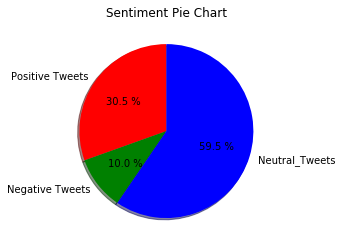

In [145]:
plt.pie([Positive_Tweets,Negative_Tweets,Neutral_Tweets],
        labels=['Positive Tweets','Negative Tweets','Neutral_Tweets'],
        colors=['r','g','b'],
        startangle=90,
        shadow= True,
        autopct='%1.1f %%')
plt.title('Sentiment Pie Chart')
plt.savefig(' sentiment')